In [1]:
from transformers import pipeline
import pandas as pd
import fasttext
import urllib.request

In [2]:
df = pd.read_csv("/kaggle/input/amazon-reviews/merged_data.csv")

In [3]:
df.head()

,reviews
0,NaN
1,NaN
2,"OnePlus has outdone itself this time, deliveri..."
3,A powerhouse of performance and style! ✨ The s...
4,No phone can be rated 5 out of 5. At the best ...


In [4]:
df.isnull().sum()

reviews    1118
dtype: int64

In [5]:
df1 = df.dropna()

In [6]:
df1.shape

(8047, 1)

In [7]:
df1 = df1.reset_index(drop=True)

In [8]:
import re
def preprocess(text):
    text = re.sub("\\n"," ",text)
    return text

In [9]:
df1['preprocessed'] = df1['reviews'].apply(preprocess)

In [10]:
url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
urllib.request.urlretrieve(url, "lid.176.bin")

# Load model
model = fasttext.load_model("lid.176.bin")

# Test detection
print(model.predict("This is an English review."))  # Expected: __label__en
print(model.predict("Ceci est un avis en français."))  # Expected: __label__fr

(('__label__en',), array([0.95950234]))
(('__label__fr',), array([0.99683094]))


In [11]:
def remove_other_languages(text):
    if model.predict(text)[0][0] == '__label__en':
        return text
    else:
        return ''
df1['eng_reviews'] = df1['preprocessed'].apply(remove_other_languages)

In [12]:
df1

,reviews,preprocessed,eng_reviews
0,"OnePlus has outdone itself this time, deliveri...","OnePlus has outdone itself this time, deliveri...","OnePlus has outdone itself this time, deliveri..."
1,A powerhouse of performance and style! ✨ The s...,A powerhouse of performance and style! ✨ The s...,A powerhouse of performance and style! ✨ The s...
2,No phone can be rated 5 out of 5. At the best ...,No phone can be rated 5 out of 5. At the best ...,No phone can be rated 5 out of 5. At the best ...
3,Surprisingly good product for the price.\nI ha...,Surprisingly good product for the price. I hav...,Surprisingly good product for the price. I hav...
4,Bought the phone a month ago. Safe to say at t...,Bought the phone a month ago. Safe to say at t...,Bought the phone a month ago. Safe to say at t...
...,...,...,...
8042,Too much Fast Battery draining it's expensive ...,Too much Fast Battery draining it's expensive ...,Too much Fast Battery draining it's expensive ...
8043,Excellent product and it is well packed on arr...,Excellent product and it is well packed on arr...,Excellent product and it is well packed on arr...
8044,The laptop is nice but not that good. I was ex...,The laptop is nice but not that good. I was ex...,The laptop is nice but not that good. I was ex...
8045,Since first day i am facing wifi adapter probl...,Since first day i am facing wifi adapter probl...,Since first day i am facing wifi adapter probl...


In [13]:
df2 = pd.DataFrame()
df2 = df1[df1['eng_reviews'].str.len()>0]

In [14]:
df2.shape

(7763, 3)

In [18]:
import torch
device = 0 if torch.cuda.is_available() else -1
model = pipeline("sentiment-analysis",
                 model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
                 tokenizer="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
                 truncation=True,
                 device = device)

Device set to use cuda:0


In [19]:
sentiment = []
def predict_sentiment(text,id):
    try:
        sentiment.append(model(text)[0]['label'])
    except RuntimeError:
        sentiment.append('')
        print("failed for",id)
for i,text in enumerate(df2['eng_reviews']):
    predict_sentiment(text, i)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [21]:
df2['sentiments'] = sentiment

<ipython-input-21-6c1f5ad0c98f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['sentiments'] = sentiment


In [37]:
df2['sentiments'].unique()

<function ndarray.sum>

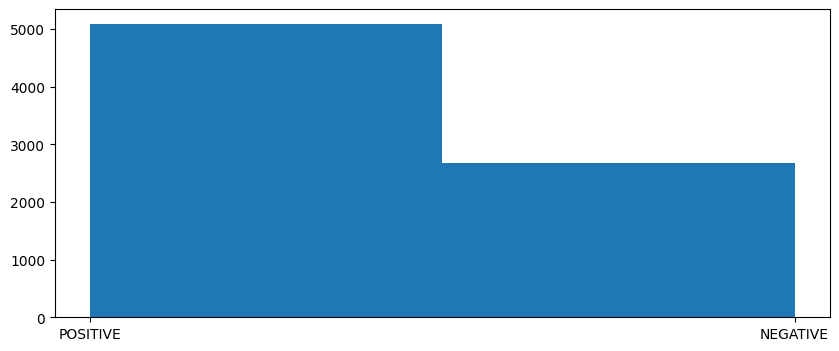

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.hist(sentiment, bins=2)
plt.show()

In [39]:
df3 = df2.iloc[:, -2:]

In [40]:
df3

,eng_reviews,sentiments
0,"OnePlus has outdone itself this time, deliveri...",POSITIVE
1,A powerhouse of performance and style! ✨ The s...,POSITIVE
2,No phone can be rated 5 out of 5. At the best ...,NEGATIVE
3,Surprisingly good product for the price. I hav...,POSITIVE
4,Bought the phone a month ago. Safe to say at t...,POSITIVE
...,...,...
8042,Too much Fast Battery draining it's expensive ...,NEGATIVE
8043,Excellent product and it is well packed on arr...,POSITIVE
8044,The laptop is nice but not that good. I was ex...,NEGATIVE
8045,Since first day i am facing wifi adapter probl...,NEGATIVE


In [41]:
df3.to_csv("amazon_review_dataset.csv", index=False)